In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from joblib import Parallel, delayed
from pyevtk.hl import pointsToVTK
from scripts.halo_analysis_scripts import *
from firestudio.studios.gas_studio import GasStudio
%matplotlib inline
plt.rcParams['figure.dpi'] = 110

palettable colormaps are not installed
don't have phil's colormaps
Missing firefly, obtain it at http://github.com/ageller/Firefly or pip install firefly.


In [3]:
'''Given set of gas particle ids, find matching particles at snapnum and save their coordinates relative to halo center in units ckpc.'''
def find_particles_snapnum(snapdir, snapnum, scale_factor_all, ids, fn_out):
    p0 = load_allparticles(snapdir, snapnum, particle_types=[0,1], keys_to_extract={0:['Coordinates','Masses', 'ParticleIDs'],1:['Coordinates', 'Masses']}, ptype_centering=1, Rvir='find_Rvir_SO', loud=False)[0]
    scale_factor = scale_factor_all[snapnum]
    
    _, idx1, idx2 = np.intersect1d(ids, p0['ParticleIDs'], return_indices=True)
    coordinates_scaled = ((p0['Coordinates'][idx2] - p0['posC'])/ scale_factor).copy()
    pids = p0['ParticleIDs'][idx2].copy()
    
    x, y, z = coordinates_scaled[:,0].copy(), coordinates_scaled[:,1].copy(), coordinates_scaled[:,2].copy()
    pointsToVTK(fn_out + f'_particletrack_snapnum{snapnum:02}', x, y, z, data={'ParticleIDs':pids})
    
    return coordinates_scaled, pids

In [2]:
simname = 'm13h206_m3e5_MHDCRspec1_fire3_fireBH_fireCR1_Oct252021_crdiffc1_sdp1e-4_gacc31_fa0.5_fcr1e-3_vw3000'
snapdir = sim_path_fire3(simname)
scale_factor_all = np.loadtxt(os.path.join(snapdir, 'snapshot_scale-factors.txt'))

# Load z=0
snapnum = 60
part = load_allparticles(snapdir, snapnum, particle_types=[0,1], keys_to_extract={0:['Coordinates','Masses','Metallicity','SmoothingLength','Temperature', 'ParticleIDs'],1:['Coordinates', 'Masses']}, ptype_centering=1, Rvir='find_Rvir_SO', loud=True)
p0 = part[0]
scale_factor = scale_factor_all[snapnum]

# Load z=z0 (snapnum = 0)
p0_initial = load_allparticles(snapdir, snapnum=0, particle_types=[0,1], keys_to_extract={0:['Coordinates','Masses','Metallicity','SmoothingLength','Temperature', 'ParticleIDs'],1:['Coordinates', 'Masses']}, ptype_centering=1, Rvir='find_Rvir_SO', loud=True)[0]
scale_factor_initial = scale_factor_all[0]

/scratch3/01799/phopkins/fire3_suite_done/m13h206_m3e5/m13h206_m3e5_MHDCRspec1_fire3_fireBH_fireCR1_Oct252021_crdiffc1_sdp1e-4_gacc31_fa0.5_fcr1e-3_vw3000/output/snapshot_060.hdf5
This is a cosmological snapshot... converting to physical units
loading: Coordinates	done.
loading: ElectronAbundance	done.
loading: InternalEnergy	done.
loading: Masses	done.
loading: Metallicity	done.
loading: ParticleIDs	done.
loading: SmoothingLength	done.
/scratch3/01799/phopkins/fire3_suite_done/m13h206_m3e5/m13h206_m3e5_MHDCRspec1_fire3_fireBH_fireCR1_Oct252021_crdiffc1_sdp1e-4_gacc31_fa0.5_fcr1e-3_vw3000/output/snapshot_060.hdf5
This is a cosmological snapshot... converting to physical units
loading: Coordinates	done.
loading: Masses	done.
Loading redshift -2.220446049250313e-16
/scratch3/01799/phopkins/fire3_suite_done/m13h206_m3e5/m13h206_m3e5_MHDCRspec1_fire3_fireBH_fireCR1_Oct252021_crdiffc1_sdp1e-4_gacc31_fa0.5_fcr1e-3_vw3000/output/snapshot_000.hdf5
This is a cosmological snapshot... converting 

In [4]:
p0['Rvir']

479.57962

## Particle forward-tracking via z=0 particle back-tracking

In [5]:
# Find particles at z=0 within 10 ckpc of galaxy center

dist_scaled = p0['r_scaled'] * p0['Rvir'] / scale_factor # distance relative to center in units comoving kpc
idx = dist_scaled<10
ids = p0['ParticleIDs'][idx]

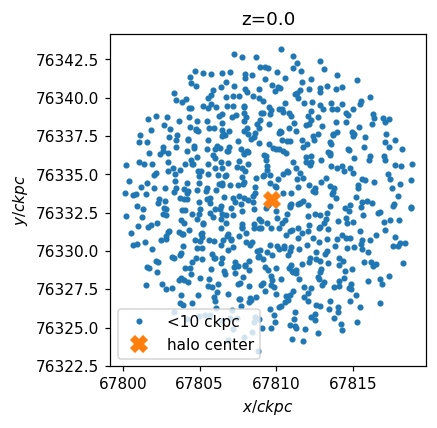

In [6]:
plt.plot(p0['Coordinates'][idx,0] / scale_factor, p0['Coordinates'][idx,1] / scale_factor, '.', label='<10 ckpc')
plt.plot(p0['posC'][0], p0['posC'][1], 'X', ms=10, label='halo center')
plt.xlabel('$x/ckpc$')
plt.ylabel('$y/ckpc$')
plt.title('z=0.0')
plt.gca().set_aspect('equal')
plt.legend()

In [7]:
# Find those particles at initial snapshot
_, idxi, idxf = np.intersect1d(p0_initial['ParticleIDs'], ids, return_indices=True)
assert len(ids)==len(idxi), 'Some particle(s) missing at z=z0'

# Find their COM in units ckpc
com_initial = center_of_mass(p0_initial['Coordinates'][idxi]/scale_factor_initial, p0_initial['Masses'][idxi])

# Find particles at z=z0 within 100 ckpc of CoM of particles
idx_initial = np.linalg.norm(p0_initial['Coordinates']/scale_factor_initial - com_initial, axis=1)<100
ids_initial = p0_initial['ParticleIDs'][idx_initial]
print(f'Found {len(ids_initial)} particles at z={p0_initial["Redshift"]:.1f}')

Found 104 particles at z=99.0


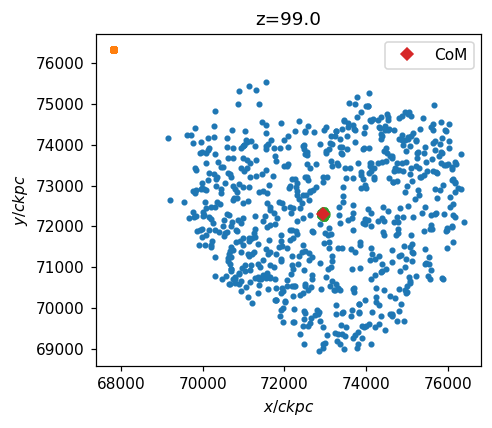

In [8]:
plt.plot(p0_initial['Coordinates'][idxi,0]/scale_factor_initial, p0_initial['Coordinates'][idxi,1]/scale_factor_initial, '.')

plt.plot(p0['Coordinates'][idx,0]/scale_factor, p0['Coordinates'][idx,1]/scale_factor, '.')
plt.plot(p0_initial['Coordinates'][idx_initial,0]/scale_factor_initial, p0_initial['Coordinates'][idx_initial,1]/scale_factor_initial, '.')
plt.plot(com_initial[0], com_initial[1], 'D', label='CoM')

plt.xlabel('$x/ckpc$')
plt.ylabel('$y/ckpc$')
plt.title(f'z={p0_initial["Redshift"]:.1f}')
plt.gca().set_aspect('equal')
plt.legend()

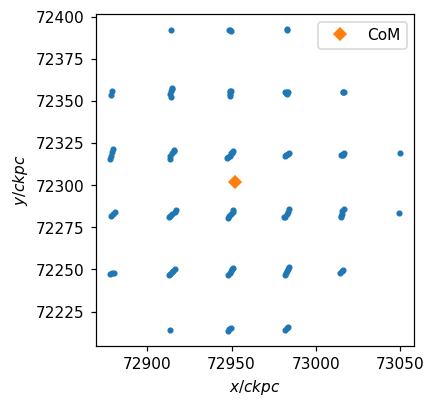

In [9]:
plt.plot(p0_initial['Coordinates'][idx_initial,0]/scale_factor_initial, p0_initial['Coordinates'][idx_initial,1]/scale_factor_initial, '.')
plt.plot(com_initial[0], com_initial[1], 'D', label='CoM')

plt.xlabel('$x/ckpc$')
plt.ylabel('$y/ckpc$')
plt.gca().set_aspect('equal')
plt.legend()

In [10]:
# Track particles across all snapshots and save coordinates
fn_out = 'data/vtk_particletrack/' + simname

particles_acrosstime = Parallel(n_jobs=-1, verbose=10)(delayed(find_particles_snapnum)(snapdir, i, scale_factor_all, ids_initial, fn_out) for i in range(61))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 56 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  61 | elapsed:   48.1s remaining:  7.4min
[Parallel(n_jobs=-1)]: Done  13 out of  61 | elapsed:   51.6s remaining:  3.2min
[Parallel(n_jobs=-1)]: Done  20 out of  61 | elapsed:   54.8s remaining:  1.9min
[Parallel(n_jobs=-1)]: Done  27 out of  61 | elapsed:   55.5s remaining:  1.2min
[Parallel(n_jobs=-1)]: Done  34 out of  61 | elapsed:   57.5s remaining:   45.6s
[Parallel(n_jobs=-1)]: Done  41 out of  61 | elapsed:   59.5s remaining:   29.0s
[Parallel(n_jobs=-1)]: Done  48 out of  61 | elapsed:  1.1min remaining:   17.9s
[Parallel(n_jobs=-1)]: Done  55 out of  61 | elapsed:  1.2min remaining:    7.6s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:  1.6min finished


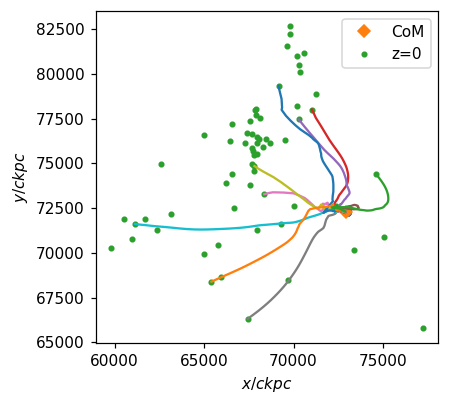

In [48]:
plt.plot(p0_initial['Coordinates'][idx_initial,0]/scale_factor_initial, p0_initial['Coordinates'][idx_initial,1]/scale_factor_initial, '.')
plt.plot(com_initial[0], com_initial[1], 'D', label='CoM')

_, idxi2, idxf2 = np.intersect1d(ids_initial, p0['ParticleIDs'], return_indices=True)
plt.plot(p0['Coordinates'][idxf2,0]/scale_factor, p0['Coordinates'][idxf2,1]/scale_factor, '.', label='z=0')

for ip in range(10):
    plt.plot( [c[ip][0] for c,i in particles_acrosstime], [c[ip][1] for c,i in particles_acrosstime])

plt.xlabel('$x/ckpc$')
plt.ylabel('$y/ckpc$')
plt.gca().set_aspect('equal')
plt.legend()

## Particle forward-tracking: 100 random particles within 20% of central region at $z=z_0$

In [14]:
# Find particles at z=z0 within 10 ckpc of galaxy center

d0 = p0_initial['r_scaled'] * p0_initial['Rvir'] / scale_factor_initial 
coordinates_scaled_initial = ((p0_initial['Coordinates'] - p0_initial['posC'])/ scale_factor_initial) # position relative to center in units comoving kpc
# idx = coordinates_scaled<10
# ids = p0['ParticleIDs'][idx]

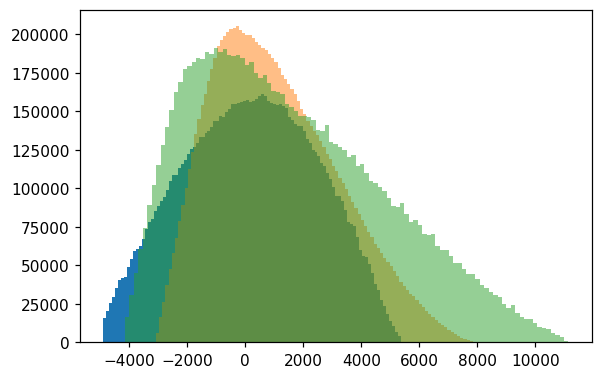

In [47]:
plt.hist(coordinates_scaled_initial[:,0], bins=100);
plt.hist(coordinates_scaled_initial[:,1], bins=100, alpha=.5);
plt.hist(coordinates_scaled_initial[:,2], bins=100, alpha=.5);

In [83]:
np.sort(d0)[int(len(d0)*0.90)] * 0.25

1811.8223876953125

In [84]:
ids_initial2 = np.random.choice(p0_initial['ParticleIDs'][d0<_], 100)

In [85]:
# Track particles across all snapshots and save coordinates
fn_out = 'data/vtk_particletrack2/' + simname

particles_acrosstime = Parallel(n_jobs=-1, verbose=10)(delayed(find_particles_snapnum)(snapdir, i, scale_factor_all, ids_initial2, fn_out) for i in range(61))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 56 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  61 | elapsed:   50.0s remaining:  7.6min
[Parallel(n_jobs=-1)]: Done  13 out of  61 | elapsed:   51.9s remaining:  3.2min
[Parallel(n_jobs=-1)]: Done  20 out of  61 | elapsed:   54.2s remaining:  1.9min
[Parallel(n_jobs=-1)]: Done  27 out of  61 | elapsed:   54.8s remaining:  1.1min
[Parallel(n_jobs=-1)]: Done  34 out of  61 | elapsed:   56.0s remaining:   44.5s
[Parallel(n_jobs=-1)]: Done  41 out of  61 | elapsed:   58.1s remaining:   28.4s
[Parallel(n_jobs=-1)]: Done  48 out of  61 | elapsed:  1.1min remaining:   17.8s
[Parallel(n_jobs=-1)]: Done  55 out of  61 | elapsed:  1.2min remaining:    7.7s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:  1.6min finished


# FIREStudio tests

projecting 275554 particles
------------------------------------------
------------------------------------------
minmax(weightMap) 0.0 1.4483404e-11
Fraction deposited: 0.9999999
minmax(weightWeightedQuantityMap) 0.0 0.0
-done
inner_weight_along_los(GasStudio instance, None, 'Masses', None, 'logT'){} 0.33 s elapsed
min_logT =  3
max_logT =  8
Image range (logT):  4.2559776 8.643942
Image range (8bit):  64.054855 255.0


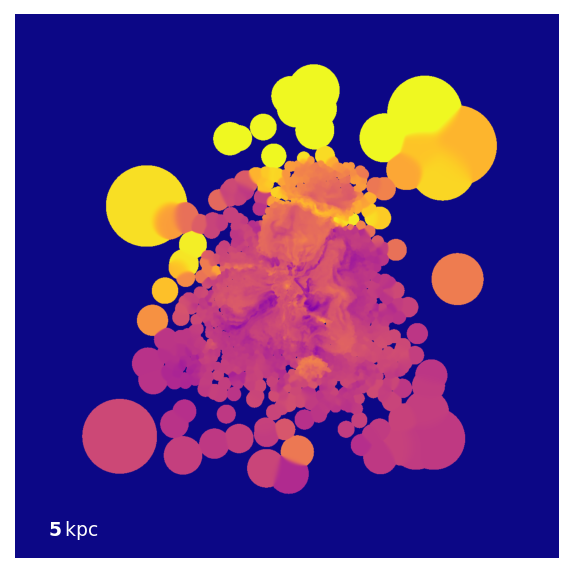

In [81]:
datadir='vizdata'
outdir='vizimages'
boxsize=40000
frame_half_thickness=20
tmin=3
tmax=8
use_metadata=False
weight_name='Masses'
quantity_name='logT'



fig, ax = plt.subplots(1, 1, figsize=[4.8,4.8], dpi=150)
gaspart = {}
gaspart['Coordinates'] = p0['Coordinates'] - p0['posC']
gaspart['Masses'] = p0['Masses'] / 1.e10
gaspart['Metallicity'] = p0['Metallicity']
gaspart['SmoothingLength'] = p0['SmoothingLength']
gaspart['BoxSize'] = boxsize
gaspart['Temperature'] = p0['Temperature']
gaspart['logT'] = np.log10(p0['Temperature'])

gasStudio = GasStudio(
    datadir=datadir, 
    snapnum=snapnum,
    sim_name=simname,
    gas_snapdict = gaspart,
    frame_half_width = boxsize//2,
    frame_half_thickness = frame_half_thickness,
    loud=False)

gasStudio.render(ax=ax, 
             weight_name=weight_name,
             quantity_name=quantity_name,
             min_quantity=tmin,
             max_quantity=tmax,
             cmap='plasma',
             use_metadata=use_metadata);
# plt.title(f"z={str(np.around(p0['Redshift'],2)).zfill(2)}, {simname}")